In [1]:
#Library imports for torch

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Setting torch seed to manual
torch.manual_seed(10)

In [2]:
# Initializing dataloaders for the CIFAR-10 dataset

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle=True)

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# CNN network implementation for deepproblog

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.MINST = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.MaxPool2d(2, 2),  # 6 24 24 -> 6 12 12
            nn.ReLU(True),
            nn.Conv2d(6, 16, 5),  # 6 12 12 -> 16 8 8
            nn.MaxPool2d(2, 2),  # 16 8 8 -> 16 4 4
            nn.ReLU(True),
        )
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.softmax = nn.Softmax(1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #x = self.MINST(x)
        x = self.softmax(x)
        return x
    
net = Net()

In [4]:
# Deepproblog dataset class implementation for formatting tensor data to query terms

from deepproblog.dataset import Dataset
from deepproblog.query import Query
from problog.logic import Term, Constant, Not

class CIFAR10Dataset(Dataset):
    def __init__(self, dataset_name: str, dataset):
        super(CIFAR10Dataset).__init__()
        
        self.dataset_name = dataset_name
        self.dataset = dataset.dataset
        
    def __getitem__(self, index):
        
        return self.dataset[int(index[0])][0]
        
    def to_query(self, i):
        
        def num_to_label(num):
            dictionary = {
            0:"plane",
            1:"car",
            2:"bird",
            3:"cat",
            4:"deer",
            5:"dog",
            6:"frog",
            7:"horse",
            8:"ship",
            9:"truck" }
            
            return dictionary[num]
      
        
        image, label = self.dataset[i]
        
        subs = dict()
                    
        subs[Term("a")] = Term("tensor", Term(self.dataset_name, Constant(i)))
        
        labels = num_to_label(label)
        
        if label in [0, 1, 8, 9]:
            is_vehicle = "true"
        else:
            is_vehicle = "false"
            
        if label in [0, 1, 8, 9]:
            has_engine = "true"
        else:
            has_engine = "false"
            
        if label in [3, 5, 7]:
            is_pet = "true"
        else:
            is_pet = "false"
            
        if label in [6, 8]:
            can_swim = "true"
        else:
            can_swim = "false"
            
        if label in [0, 2]:
            can_fly = "true"
        else:
            can_fly = "false"
            
        if label in [2, 3, 5]:
            is_small = "true"
        else:
            is_small = "false"
        
        q = Query(Term("attributes", Term("a"), Constant(is_vehicle), Constant(is_pet), 
                       Constant(can_swim), Constant(can_fly), Constant(is_small), Constant(has_engine), Constant(labels)), subs)  
                
        return q
    
    def __len__(self):
        return len(self.dataset)

In [5]:
# Deepproblog model implementation for B2 background knowledge

from deepproblog.model import Model
from deepproblog.network import Network
from deepproblog.train import train_model
from deepproblog.heuristics import geometric_mean
from deepproblog.engines import ExactEngine, ApproximateEngine
from deepproblog.dataset import DataLoader
from deepproblog.evaluate import get_confusion_matrix
from deepproblog.optimizer import SGD
from deepproblog.heuristics import geometric_mean
from deepproblog.utils.stop_condition import StopOnPlateau, Threshold

new_net = Net()
dpl_net = Network(new_net, "sample_deepprobllog", batching=True)
dpl_net.optimizer = optim.SGD(new_net.parameters(), lr=0.01)


# Background B2 file
dpl_model = Model("background/mnist_b2.pl", [dpl_net])

train_dataset = CIFAR10Dataset("train", trainloader)
test_dataset = CIFAR10Dataset("test", testloader)

dataloader = DataLoader(train_dataset, batch_size = 4)

dpl_model.add_tensor_source("train", train_dataset)
dpl_model.add_tensor_source("test", test_dataset)

dpl_model.set_engine(ExactEngine(dpl_model) , cache=True)

dpl_model.optimizer = SGD(dpl_model, 0.01)

train = train_model(dpl_model, dataloader, 2, log_iter=2000)

train.logger.write_to_file("./B2")

Caching ACs
Training  for 2 epoch(s)
Epoch 1
Iteration:  2000 	s:33.9956 	Average Loss:  2.220983515702188
Iteration:  4000 	s:32.8717 	Average Loss:  1.862782876426354
Iteration:  6000 	s:33.6566 	Average Loss:  1.6635075249993243
Iteration:  8000 	s:34.7289 	Average Loss:  1.587313122497173
Iteration:  10000 	s:34.9365 	Average Loss:  1.4982570580370957
Iteration:  12000 	s:35.5453 	Average Loss:  1.4649949114290066
Epoch time:  214.72746205329895
Epoch 2
Iteration:  14000 	s:35.5994 	Average Loss:  1.4144765080765647
Iteration:  16000 	s:35.0150 	Average Loss:  1.3790417298580577
Iteration:  18000 	s:35.0431 	Average Loss:  1.336799027872803
Iteration:  20000 	s:35.5125 	Average Loss:  1.320403187281845
Iteration:  22000 	s:33.9355 	Average Loss:  1.2934082512722689
Iteration:  24000 	s:34.4501 	Average Loss:  1.2816565063369307
Epoch time:  217.88451862335205


         	     	   	    	   	     	Actual	     	   	     	    	    
         	     	cat	ship	car	plane	  frog	truck	dog	horse	deer	bird
         	  cat	501	  53	 30	   51	   217	   35	273	   78	 151	 183
         	 ship	 46	 780	 81	  257	    19	  102	 24	   19	  55	  98
         	  car	 12	  44	701	    0	    12	  129	  3	   12	  15	   0
         	plane	  0	  63	 21	  570	     0	   20	  0	    0	   0	   0
Predicted	 frog	 46	   3	  6	    9	   507	   13	 19	    6	  64	  50
         	truck	 29	  37	137	   60	    26	  640	 11	   27	  11	  30
         	  dog	273	  12	 14	   16	    93	   28	578	  189	 124	 167
         	horse	 44	   6	  5	   18	    30	   32	 57	  624	 147	  70
         	 deer	 49	   2	  5	   19	    96	    1	 35	   45	 433	 101
         	 bird	  0	   0	  0	    0	     0	    0	  0	    0	   0	 301
Accuracy:  0.5635
Accuracy 0.5635
Accuracy:  0.5635
Accuracy is 0.5635 %
Precision [0.501, 0.78, 0.701, 0.57, 0.507, 0.64, 0.578, 0.624, 0.433, 0.301]
Recall [0.3187022900763359, 0.526

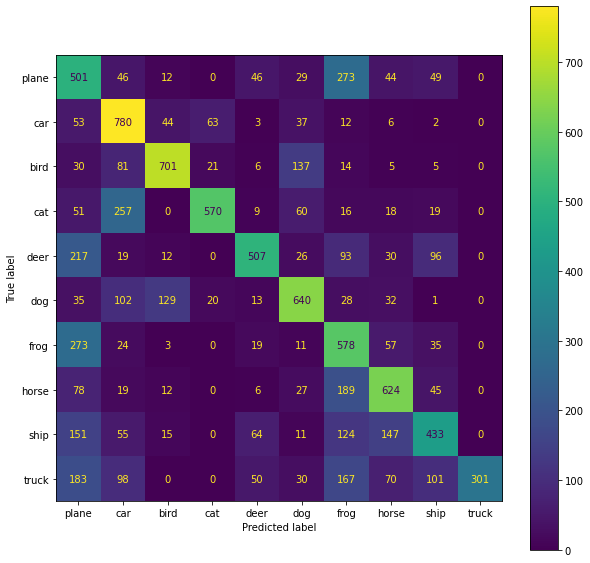

In [6]:
#Confusion and Precision & Recall metrics 

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from operator import truediv
import numpy as np

confusion_matrix = get_confusion_matrix(dpl_model, test_dataset, verbose=1)

fig, ax = plt.subplots(figsize=(10,10))

cd = ConfusionMatrixDisplay(confusion_matrix.matrix.transpose(), display_labels=classes)
cd.plot(ax=ax)

# Saving Confusion matrix for B2 model
fig.savefig("images/B2.png")

        
print(f"Accuracy is {confusion_matrix.accuracy()} %")

# Precision and Recall scores

cm = confusion_matrix.matrix
tp = np.diag(cm)
precision = list(map(truediv, tp, np.sum(cm, axis=0)))
recall = list(map(truediv, tp, np.sum(cm, axis=1)))
print(f"Precision {precision}\nRecall {recall}")